# Imports


In [1]:

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import shutil
import time
import os

# Data Proccesing 

In [2]:
# Set the path to the dataset directory
images_path = "../datasets/dog-pose-class/images"
annot_path = "../datasets/dog-pose-class/releases/4/annotations"

In [3]:
# create an empty list to store the results
results = []

# iterate over each file in the directory
for file_name in os.listdir(annot_path):
    if file_name.endswith('.json'):
        # read the JSON file
        with open(os.path.join(annot_path, file_name), 'r') as f:
            json_data = json.load(f)
        try:
            # extract the necessary fields
            file_path = f"{images_path}/{json_data['item']['slots'][0]['source_files'][0]['file_name']}"
            label = json_data['annotations'][0]['name']
            # append the results to the list
            if label != "None":
                results.append({'Filepath': file_path, 'Label': label})
        except Exception as e:
#             print(f"File name: {file_name} cannot mem loaded.")
            pass

# convert the results list to a dataframe
df = pd.DataFrame(results)

In [4]:
print('Total number of images:', len(df))

Total number of images: 4430


In [5]:
df.head()

,Filepath,Label
0,../datasets/dog-pose-class/images/n02087046_51...,Standing
1,../datasets/dog-pose-class/images/n02089867_18...,Sitting
2,../datasets/dog-pose-class/images/n02099849_54...,Sitting
3,../datasets/dog-pose-class/images/n02089973_25...,Standing
4,../datasets/dog-pose-class/images/n02093754_44...,Sitting


In [6]:
# Get the count of each dog breed in the dataset
label_count = pd.value_counts(df['Label'], ascending=False)
print('Dog poses:')
print(label_count.tail(3))

Dog poses:
Standing    1887
Lying       1440
Sitting     1103
Name: Label, dtype: int64


## Normalize the amount of data per class

In [7]:
# Get the unique labels and their frequencies
label_counts = df["Label"].value_counts()
unique_labels = label_counts.index.tolist()

# Determine the number of samples to use for each label
num_samples_per_label = label_counts.min()

# Group the data by label
grouped_data = df.groupby("Label")
np.random.seed(42)  # Set the random seed to a fixed value

# Sample a fixed number of samples from each group
sampled_data = pd.DataFrame(columns=["Filepath", "Label"])
for label in unique_labels:
    label_data = grouped_data.get_group(label)
    sampled_indices = np.random.choice(len(label_data), num_samples_per_label, replace=False)
    sampled_data = sampled_data.append(label_data.iloc[sampled_indices])
    
df = sampled_data.reset_index(drop=True)

/tmp/ipykernel_20321/678819749.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_data = sampled_data.append(label_data.iloc[sampled_indices])
/tmp/ipykernel_20321/678819749.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_data = sampled_data.append(label_data.iloc[sampled_indices])
/tmp/ipykernel_20321/678819749.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_data = sampled_data.append(label_data.iloc[sampled_indices])


In [8]:
# Get the count of each dog breed in the dataset
label_count = df.value_counts(df['Label'], ascending=False)
print('Dog poses:')
print(label_count.tail(3))

Dog poses:
Label
Lying       1103
Sitting     1103
Standing    1103
dtype: int64


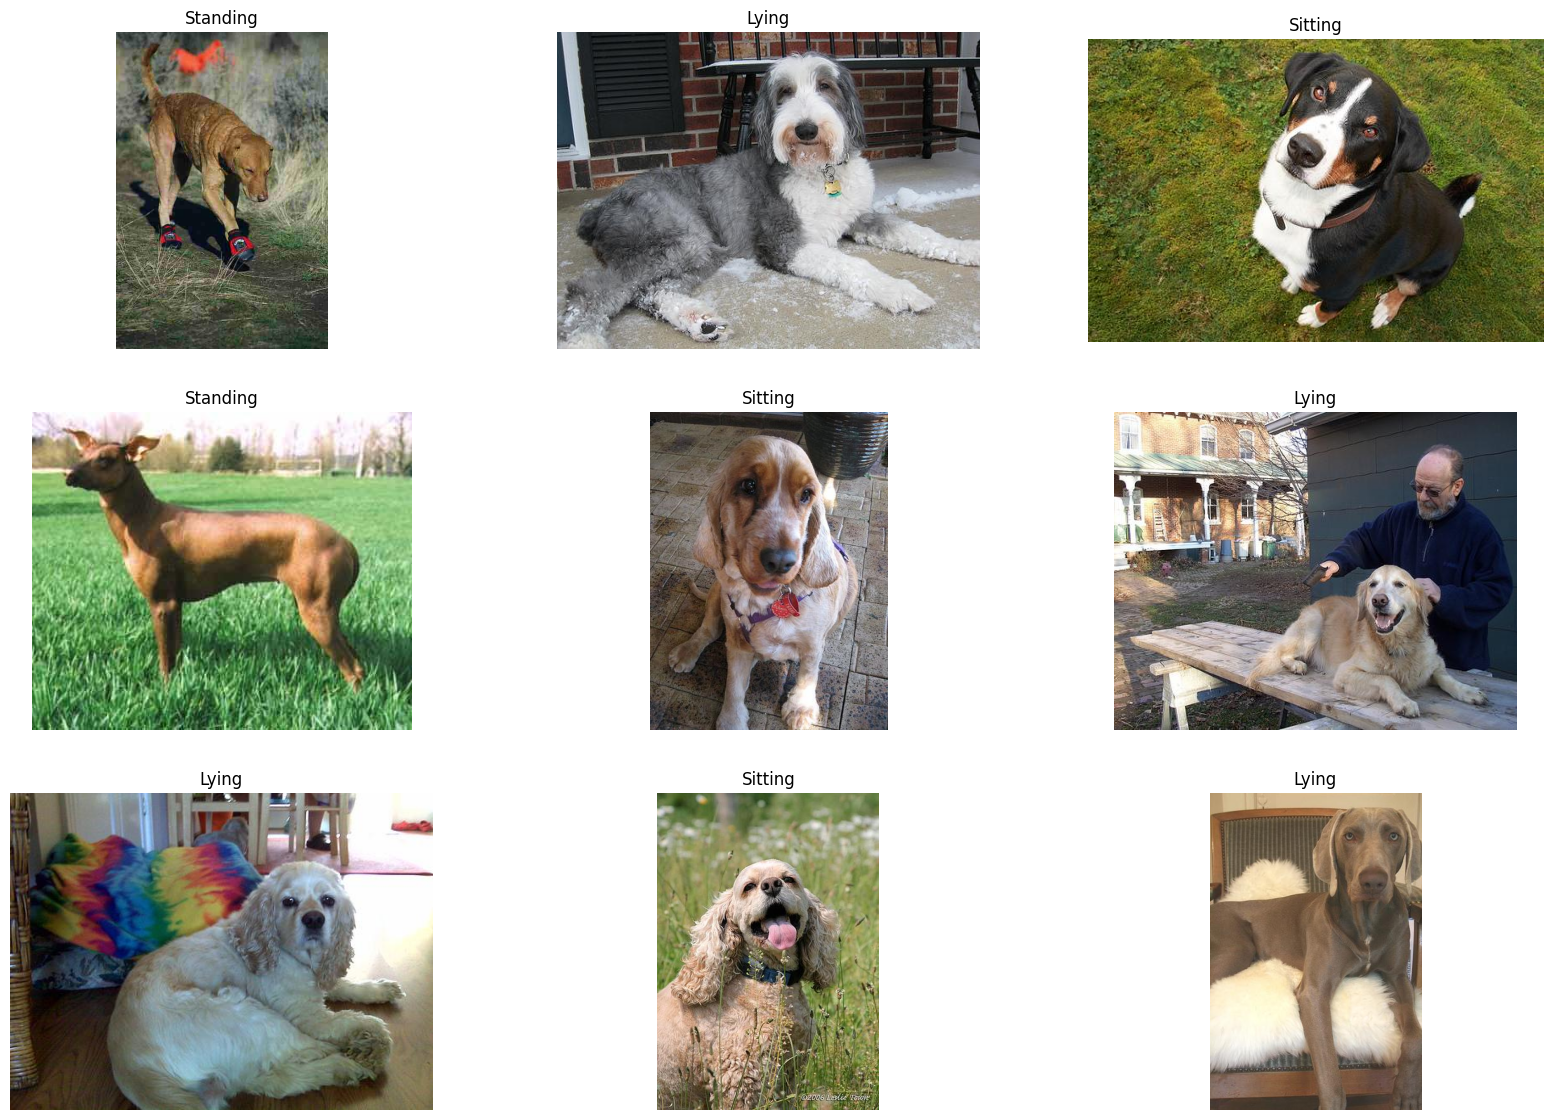

In [9]:
# Randomly select a subset of samples to display
num_samples_to_display = 9
sample_indices = np.random.choice(len(df), num_samples_to_display, replace=False)
sample_df = df.iloc[sample_indices]

# Display the sample images
fig, axis = plt.subplots(num_samples_to_display//3, 3, figsize=(20, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(sample_df.Filepath.iloc[i]))
    ax.set_title(sample_df.Label.iloc[i])
    ax.axis('off')
plt.show()

# Making the data split

In [10]:
# Split the dataset into training, validation, and testing sets
val_ratio = test_ratio = 0.2
train, test = train_test_split(df, test_size=test_ratio)
val, test = train_test_split(test, test_size=val_ratio)
print('Total number of samples:', len(df))
print('Number of training samples:', len(train))
print('Number of validation samples:', len(val))
print('Number of testing samples:', len(test))

Total number of samples: 3309
Number of training samples: 2647
Number of validation samples: 529
Number of testing samples: 133


In [11]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [12]:
with open("../dnn_model/pose/class.json", "r") as f:
    pose_classes = json.load(f)
    
pose_classes

{'Lying': 0, 'Sitting': 1, 'Standing': 2}

In [15]:

!mkdir ../datasets/dog-pose-yolo_dataset/train
!mkdir ../datasets/dog-pose-yolo_dataset/valid
!mkdir ../datasets/dog-pose-yolo_dataset/test


In [13]:
def extract_df(dataframe, name):
    print(f"Starting to Processing")
    count = 0
    for index, row in dataframe.iterrows():
        img_path = row['Filepath']
        img_filename = os.path.basename(img_path)
        label = row['Label']
        
        # Define new paths
        new_img_path = f"../datasets/dog-pose-yolo_dataset/{name}/{label}/{img_filename}"
        shutil.copyfile(img_path, new_img_path)
        count += 1
    print(f"Processed {count} files")

# Build the dataset 

In [17]:
extract_df(train, "train")

Starting to Processing
Processed 2647 files


In [18]:
extract_df(val, "valid")

Starting to Processing
Processed 529 files


In [19]:
extract_df(test, "test")

Starting to Processing
Processed 133 files
